# Case - OEE

Copyright © 2019 Hsu Shih-Chieh

算法筆記：https://hackmd.io/@Annie/ByeX2_qtH (by Annie)

In [9]:
%load_ext autoreload
%autoreload 2

from datasets import load_oee
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from collections import namedtuple
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from utils import set_font_cn
set_font_cn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
data = load_oee() 
print(data.DESCR)

成型機案例數據
---------------------------

**Data Set Characteristics::**

    :控制器數據: 從控制器取出的螺桿位置, 油壓缸壓力, 料管溫度的數據統計值, 總共有44種數據
    
    :機台狀態燈號: 從控制器的機台狀態數據, 定義機台燈號
    
    :spccol_mapping: PLC數據欄位的中英文對照表
    


**讀取數據Sample Code**

::

    data= load_oee()


**Model Characteristics**
    
    :稼動率: 利用機台狀態燈號, 計算機台的工作時間比例
    
    :達成率: 實際完成模次/理想應完成模次
    
    :週期時間: 完成每一模次的時間



專案說明：
與TPM合作的Phase I, 透過控制器數據與機台狀態燈號, 實時計算稼動率, 達成率, 週期時間

..  image:: img/oee_main.jpg
    :height: 400
    :width: 400


### 稼動率

In [3]:
MID='A01'
light_Mid = data.ligutstatusdata[data.ligutstatusdata['machine_id']==MID]
Availability = namedtuple('Availability', 'start_dt, end_dt, availability')
start_dt = datetime(2019,10,11,8,0)
end_dt = datetime(2019,10,11,8,0)
availability_daylist=[]
for i in range(15):
    start_dt = end_dt
    end_dt = start_dt + timedelta(hours=24)
    light_day = light_Mid[(light_Mid['timestamp']>=start_dt.timestamp()) & (light_Mid['timestamp']<=end_dt.timestamp())]
    if len(light_day)==0:
        availability=0
    else:
        #計算每一個燈號持續的時間的時間
        light_day['delta']=light_day['timestamp'].diff(1)
        #計算稼動率
        delta=light_day['timestamp'].values[-1] - light_day['timestamp'].values[0]
        availability=np.round(light_day[(light_day['light_color']=='green')]['delta'].sum()/delta*100,3)
        
    avail = Availability(start_dt=start_dt, end_dt=end_dt, availability=availability)
    availability_daylist.append(avail)



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


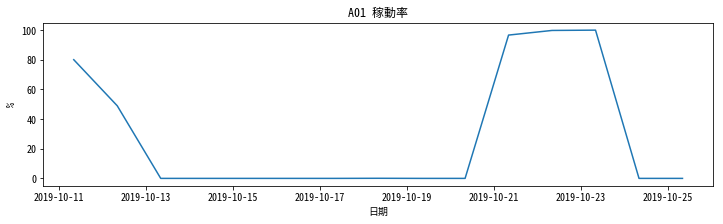

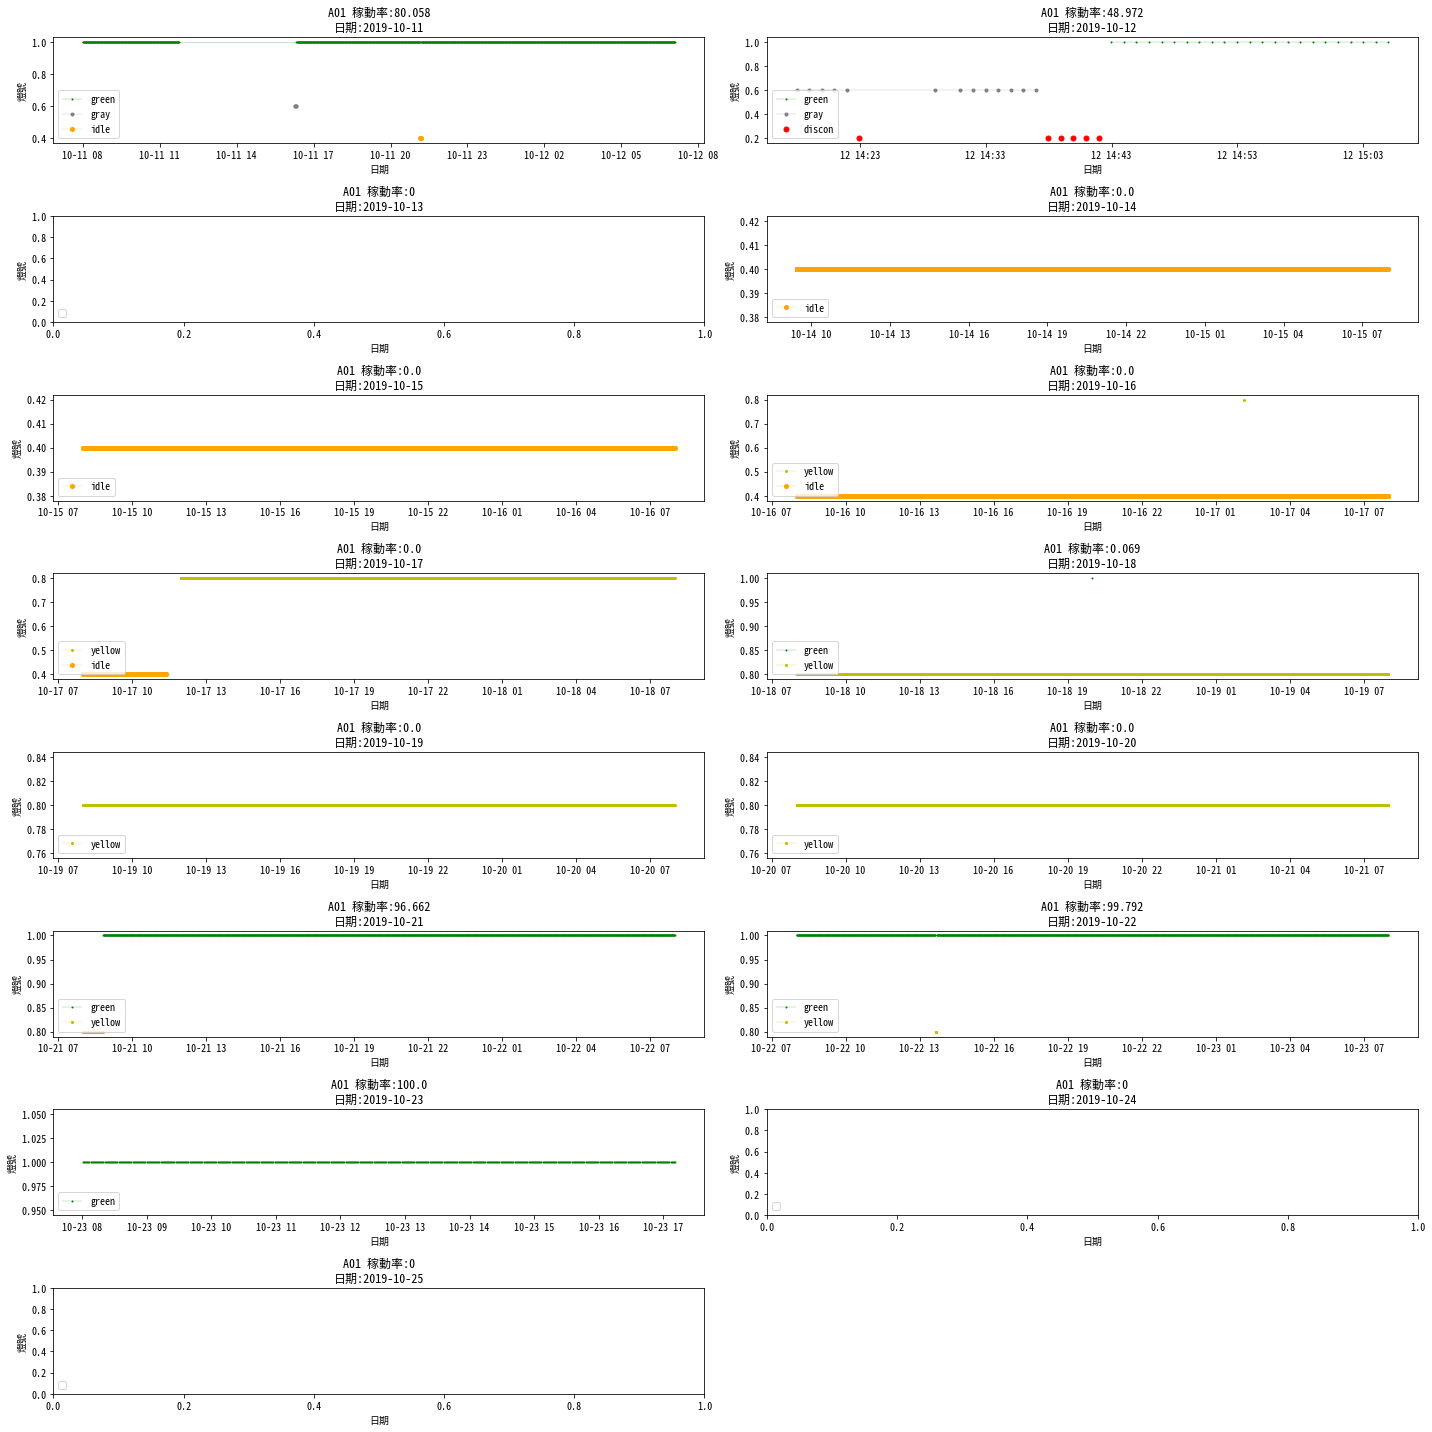

In [4]:
avail_days = list(map(lambda x: x.availability, availability_daylist))
dates = list(map(lambda x: x.start_dt, availability_daylist))
plt.figure(figsize=(12,3))
plt.plot(dates, avail_days)
plt.xlabel('日期')
plt.ylabel('%')
plt.title(f'{MID} 稼動率')
plt.show()
if True:
    plt.figure(figsize=(20,20))
    for i, avaobj in enumerate(availability_daylist):
        plt.subplot(8,2,1+i)
        light_day = light_Mid[(light_Mid['timestamp']>=avaobj.start_dt.timestamp()) & (light_Mid['timestamp']<=avaobj.end_dt.timestamp())]
        green = light_day[light_day['light_color']=='green']
        yellow = light_day[light_day['light_color']=='yellow']
        gray = light_day[light_day['light_color']=='gray']
        idle = light_day[light_day['light_color']=='icon_idle']
        icon_disconnected = light_day[light_day['light_color']=='icon_disconnected']
        if len(green)>0:
            plt.plot(green['dt'], [1]*len(green),'g.-', lw=0.2, ms=2, label='green')
        if len(yellow)>0:
            plt.plot(yellow['dt'], [0.8]*len(yellow),'y.-', lw=0.2, ms=4, label='yellow')
        if len(gray)>0:
            plt.plot(gray['dt'], [0.6]*len(gray),'.-', c='gray', lw=0.2, ms=6, label='gray')
        if len(idle)>0:
            plt.plot(idle['dt'], [0.4]*len(idle),'.-', c='orange', lw=0.2, ms=8, label='idle')
        if len(icon_disconnected)>0:
            plt.plot(icon_disconnected['dt'], [0.2]*len(icon_disconnected),'r.', lw=0.2, ms=10, label='discon')
            
        plt.legend(loc=3)
        plt.xlabel('日期')
        plt.ylabel('燈號')
        plt.title(f'{MID} 稼動率:{avaobj.availability}\n日期:{avaobj.start_dt.date()}')

    plt.tight_layout()
    plt.show()

### 達成率

In [5]:
ct_std={
    'A01':25.3,
    'A03':28,
    'A05':32,
    'A06':34,}    
yieldrate= 0.996


In [6]:
MID='A01'
spc_Mid = data.spcdata[data.spcdata['machine_id']==MID]

start_dt = datetime(2019,10,10,8,0)
end_dt = start_dt
achievelist_day =[]
for i in range(15):
    #
    start_dt = start_dt + timedelta(hours=24)
    end_dt = start_dt 
    Achieve = namedtuple('Achieve', 'start_dt, end_dt, achievingrate, achievingqty')
    achievelist=[]
    for i in range(48):
        end_dt = end_dt + timedelta(hours=0.5)
        spc_day = spc_Mid[(spc_Mid['timestamp']>=start_dt.timestamp()) & (spc_Mid['timestamp']<=end_dt.timestamp())]
        actual_num = np.floor(len(spc_day['SPC_0'].unique())*yieldrate)
        ## FIXME: 要改成真實的每日生產目標
        target_num = np.floor((end_dt-start_dt).total_seconds()/ct_std[MID])
        achievingrate = np.round(actual_num/target_num*100,3)
        ach = Achieve(start_dt=start_dt, end_dt=end_dt, achievingrate=achievingrate, achievingqty=spc_day.shape[0])
        achievelist.append(ach)
    achievelist_day.append(achievelist)


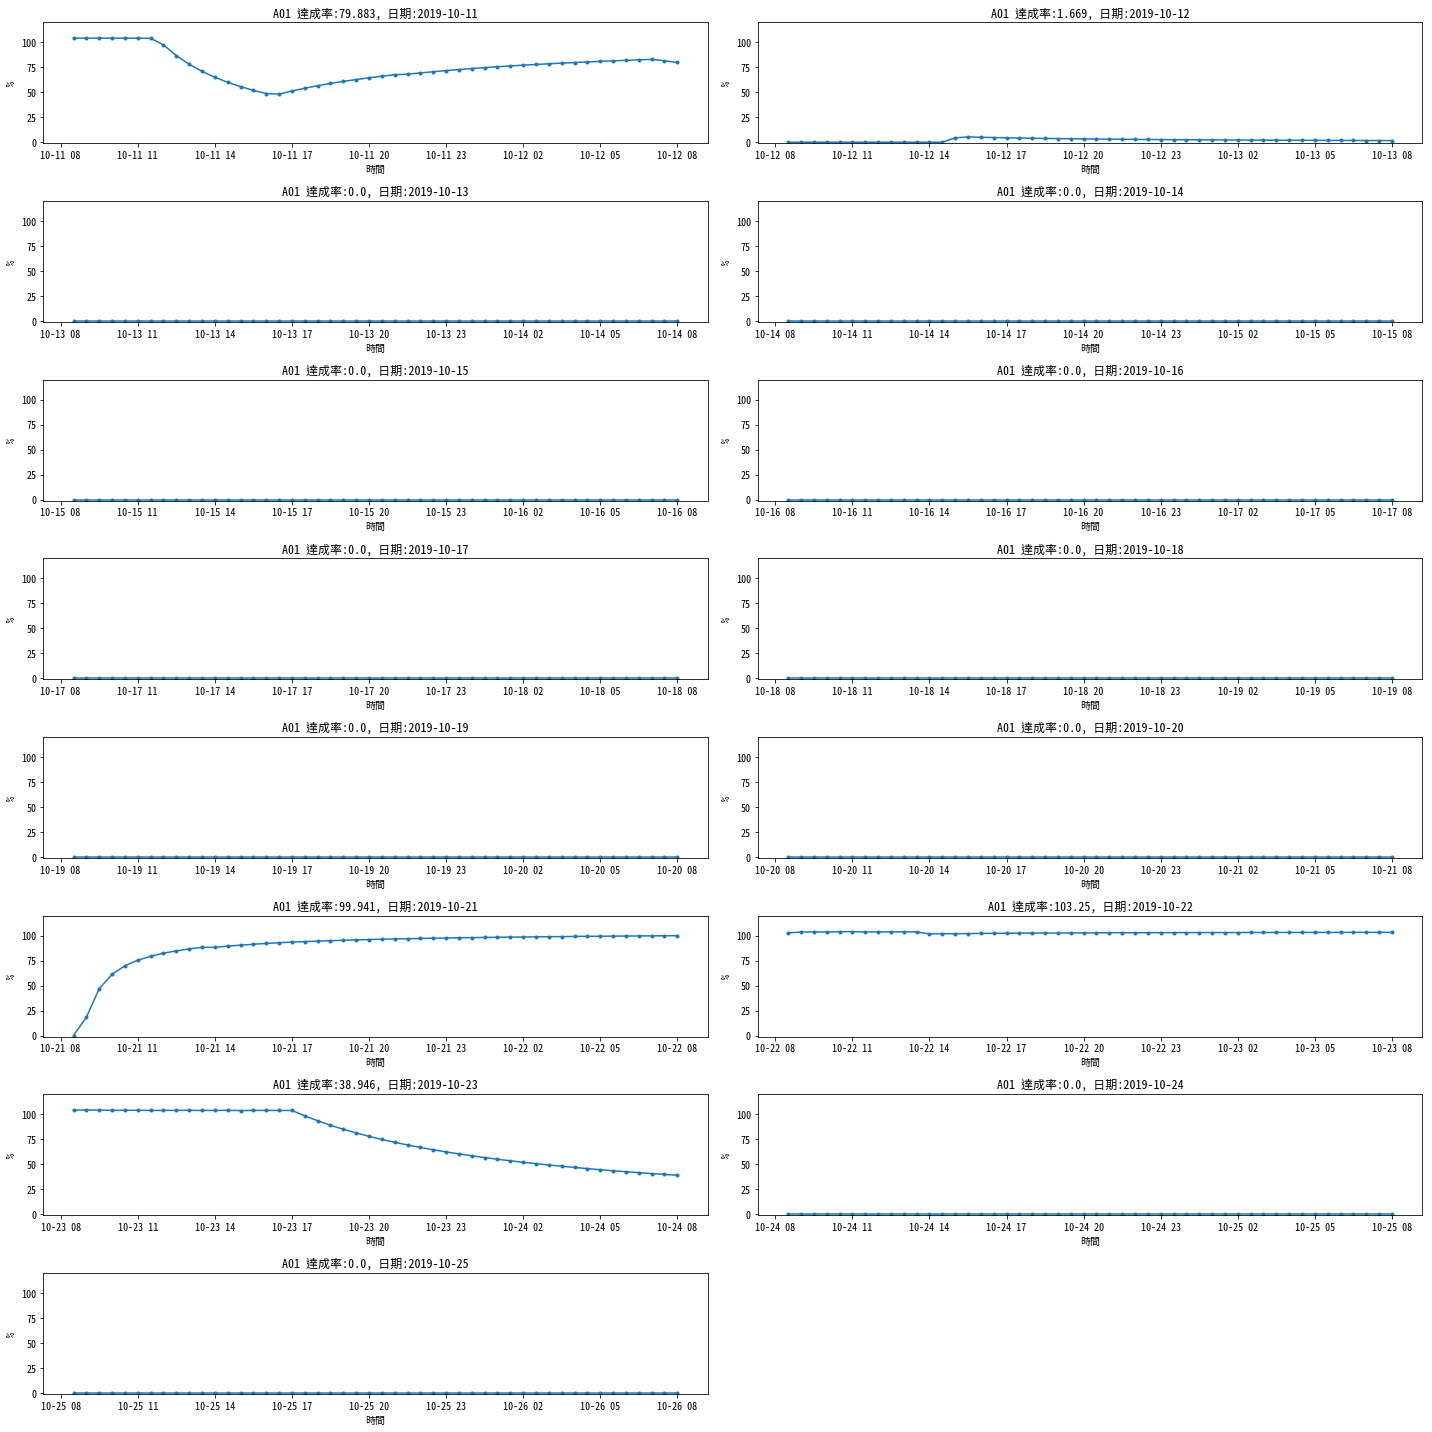

In [7]:
plt.figure(figsize=(20,20))
for i, achievelist in enumerate(achievelist_day):
    plt.subplot(8,2,1+i)
    achieverates = list(map(lambda x: x.achievingrate, achievelist))
    endtime = list(map(lambda x: x.end_dt, achievelist))
    plt.plot(endtime, achieverates, '.-')
    plt.xlabel('時間')
    plt.ylabel('%')
    plt.ylim(-1,120)
    plt.title(f'{MID} 達成率:{achieverates[-1]}, 日期:{endtime[0].date()}')
    
plt.tight_layout()
plt.show()    

### 週期時間

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


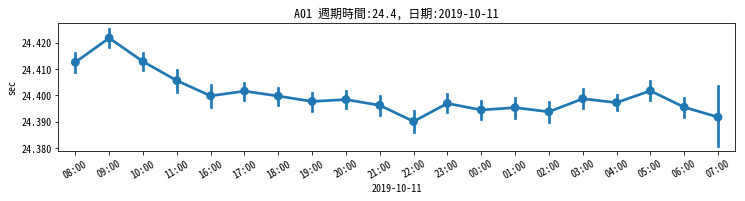

In [8]:
MID='A01'
spc_Mid = data.spcdata[data.spcdata['machine_id']==MID]

start_dt = datetime(2019,10,11,8,0)
end_dt = datetime(2019,10,11,8,0)

plt.figure(figsize=(20,20))
for i in range(1):
    plt.subplot(8,2,1+i)
    start_dt = end_dt
    end_dt = start_dt + timedelta(hours=24)
    spc_day = spc_Mid[(spc_Mid['timestamp']>=start_dt.timestamp()) & (spc_Mid['timestamp']<=end_dt.timestamp())]
    spc_day['60MIN'] = spc_day['dt'].map(lambda x: datetime(x.year, x.month, x.day, x.hour, 0 ))
    if len(spc_day)>0:
        ax = sns.pointplot(x='60MIN', y='SPC_9',  data=spc_day, estimator=np.nanmean, ci=95)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        ax.set_xticklabels([ label.split('T')[1].split('.')[0][:-3] for label in labels])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        d=labels[0].split('T')[0]
        t=np.round(spc_day['SPC_9'].mean(),1)
        plt.xlabel(d)
        plt.ylabel('sec')
        plt.xticks(rotation=30)
    else:
        t=0
    plt.title(f'{MID} 週期時間:{t}, 日期:{start_dt.date()}')        
        
plt.tight_layout()
plt.show()           